In [1]:
%load_ext autoreload
%autoreload 2
from configs import project_config
import matplotlib.pyplot as plt
import numpy as np
import torch
import matplotlib.cm as cm
from matplotlib.animation import FuncAnimation
from IPython.display import HTML, display
from scipy.stats import mannwhitneyu, ks_2samp
import os
import pickle

In [2]:
def get_true_drift(config, prev_paths):
    if "fOU" in config.data_path:
        try:
            return -config.mean_rev * (prev_paths.numpy() - config.mean)
        except AttributeError as e:
            return -config.mean_rev * (prev_paths - config.mean)
    elif "fSin" in config.data_path:
        try:
            return config.mean_rev * np.sin(prev_paths.numpy())
        except AttributeError as e:
            return config.mean_rev * np.sin(prev_paths)


In [3]:
from configs.RecursiveVPSDE.recursive_Markovian_PostMeanScore_fSin_T256_H05_tl_5data import get_config as get_config_postmean
config_postmean = get_config_postmean()
rng = np.random.default_rng()
num_simulated_paths = 500
data_shape = (num_simulated_paths, 1, 1)
device = "cpu"

real_time_scale = torch.linspace(start=1 / config_postmean.ts_length, end=1, steps=config_postmean.ts_length).to(device)

max_diff_steps = config_postmean.max_diff_steps
sample_eps = config_postmean.sample_eps
mean_rev = config_postmean.mean_rev
ts_step = 1 / config_postmean.ts_length
eval_ts_length = 256

In [4]:
from scipy.stats import wasserstein_distance
import ot
def bootstrap_test_wasserstein(sample1, sample2, num_bootstrap=1000):
    # Step 1: Compute the observed Wasserstein distance
    M = ot.dist(sample1, sample2, metric='euclidean')
    a = np.ones((sample1.shape[0],)) / sample1.shape[0]  # Uniform weights for X
    b = np.ones((sample1.shape[0],)) / sample1.shape[0]  # Uniform weights for Y

    #observed_distance = wasserstein_distance(sample1, sample2)
    print(a.shape, b.shape, M.shape)
    observed_distance = ot.lp.emd2(a, b, M = M)
    # Step 2: Bootstrap samples
    bootstrap_distances = []
    combined = np.vstack([sample1, sample2])
    for _ in range(num_bootstrap):
        np.random.shuffle(combined)
        obs_perm = combined[:sample1.shape[0], :]
        sim_perm = combined[sample2.shape[0]:, :]

        # Step 3: Compute Wasserstein distance for bootstrap samples
        M = ot.dist(obs_perm, sim_perm, metric='euclidean')
        boot_distance = (ot.lp.emd2(a, b, M = M))
        #boot_distance = wasserstein_distance(boot_sample1, boot_sample2)
        bootstrap_distances.append(boot_distance)

    # Step 4: Calculate p-value and confidence intervals
    bootstrap_distances = np.array(bootstrap_distances)
    fig, ax = plt.subplots(figsize=(14, 9))
    counts, bins, patches  = ax.hist(bootstrap_distances, bins=150, alpha=0.75,density=True)
    ax.set_title("Histogram of Permutation-Test Wasserstein Distances", fontsize=20)
    ax.axvline(observed_distance, 0, np.max(counts), color="orange", label="Observed Wasserstein Distance")
    ax.set_xlabel("Wasserstein Distances", fontsize=20)
    ax.set_ylabel("Normalised Count", fontsize=20)
    ax.legend(fontsize=18)
    ax.tick_params(labelsize=18)
    plt.savefig("/Users/marcos/Library/CloudStorage/OneDrive-ImperialCollegeLondon/StatML_CDT/Year2/DiffusionModelPresentationImages/wassersteindistances.png")
    plt.show()
    plt.close()
    p_value = np.mean(bootstrap_distances >= observed_distance)
    print(bootstrap_distances, observed_distance, p_value)

    return observed_distance, p_value

# Plot the generated paths and compare with exact paths

In [5]:
# Plot the drift estimator for different sample paths across time
for Nep in [960]:
    save_path = (project_config.ROOT_DIR + f"experiments/results/TSPM_Markovian_ES0_fSin_DriftEvalExp_{Nep}Nep_{config_postmean.loss_factor}LFactor_10MeanRev_{config_postmean.max_diff_steps}DiffSteps").replace(".","")
    try:
        postMean_prevPaths = torch.load(save_path + "_prevPaths")
        synthetic_paths = np.load(config_postmean.data_path)[np.random.choice(np.arange(config_postmean.dataSize), postMean_prevPaths.shape[0], replace=False),:]
        print(config_postmean.data_path)
        synthetic_paths = np.concatenate([np.zeros((synthetic_paths.shape[0], 1)), synthetic_paths[:,:-1]], axis=1)
        synthetic_paths = synthetic_paths[:,:postMean_prevPaths.shape[1]]
        print(bootstrap_test_wasserstein(postMean_prevPaths.numpy(), synthetic_paths)[1])
        fig, ax = plt.subplots(figsize=(14, 9))
        for pathid in range(3):
            ax.scatter(real_time_scale[:eval_ts_length].cpu(), postMean_prevPaths[pathid,:].cpu(), s=10)
        ax.set_xlabel("Time Axis $\{t_{0}, ..., t_{256}\}$", fontsize=20)
        ax.set_ylabel("Path", fontsize=20)
        ax.set_title("Paths generated using trained neural network $s_{\hat{\\theta}}$", fontsize=20)
        ax.tick_params(labelsize=18)
        plt.savefig("/Users/marcos/Library/CloudStorage/OneDrive-ImperialCollegeLondon/StatML_CDT/Year2/DiffusionModelPresentationImages/diffusionmodelpaths.png")
        plt.show()
        plt.close()
        fig, ax = plt.subplots(figsize=(14, 9))
        for pathid in range(3):
            ax.scatter(real_time_scale[:eval_ts_length].cpu(), synthetic_paths[pathid,:], s=10)
        ax.set_xlabel("Time Axis $\{t_{0}, ..., t_{256}\}$", fontsize=20)
        ax.set_ylabel("Path", fontsize=20)
        ax.set_title(f"Simulated Paths from $dX_t = \sin(X_t)dt + dB_t$", fontsize=20)
        ax.tick_params(labelsize=18)
        plt.savefig("/Users/marcos/Library/CloudStorage/OneDrive-ImperialCollegeLondon/StatML_CDT/Year2/DiffusionModelPresentationImages/simulatedpaths.png")
        plt.show()
        plt.close()
        del postMean_prevPaths
    except FileNotFoundError as e:
        print(e)

/Users/marcos/GitHubRepos/FractionalBrownianMotion/data/fSin_samples_H05_T256_10Rev_10Diff_00Init.npy
(500,) (500,) (500, 500)



KeyboardInterrupt



In [ ]:
# Plot some marginal distributions for increments
time_space = np.linspace((1. / config_postmean.ts_length), 1., num=config_postmean.ts_length)
low = 0
high = config_postmean.ts_length
Nep = [960][0]
save_path = (project_config.ROOT_DIR + f"experiments/results/TSPM_Markovian_ES0_fSin_DriftEvalExp_{Nep}Nep_{config_postmean.loss_factor}LFactor_10MeanRev_{config_postmean.max_diff_steps}DiffSteps").replace(".","")
postMean_prevPaths = torch.load(save_path + "_prevPaths").numpy()
synthetic_paths = np.load(config_postmean.data_path)[np.random.choice(np.arange(config_postmean.dataSize), postMean_prevPaths.shape[0], replace=False),:]
synthetic_paths = np.concatenate([np.zeros((synthetic_paths.shape[0], 1)), synthetic_paths[:,:-1]], axis=1)

# Plot evolution of marginal density of increments


In [ ]:
incs = np.diff(postMean_prevPaths, axis=1)[1:]
synth_incs = np.diff(synthetic_paths, axis=1)[1:]

fig, ax = plt.subplots(figsize=(10, 8))
# Initialize empty bars
_ = ax.hist([], bins=30, color='blue', alpha=0.6, label='True', edgecolor='black')[2]
_ = ax.hist([], bins=30, color='orange', alpha=0.6, label='Synthetic', edgecolor='black')[2]

# Set axis labels and title
ax.set_xlabel('Increment Value', fontsize=15)
ax.set_ylabel('Density', fontsize=15)
ax.tick_params(axis='x', labelsize=15)  # Set x-axis tick size to 12
ax.tick_params(axis='y', labelsize=15)
ax.set_title(f"Marginal Distributions for Increment", fontsize=15)
ax.legend(loc="upper right", fontsize=15)

def update(frame):
    ax.clear()  # Clear the previous histogram
    # Plot true histogram
    ax.hist(incs[:,frame], bins=50, color="blue", density=True, alpha=0.5, label='Generated')
    # Plot synthetic histogram
    ax.hist(synth_incs[:, frame], bins=50, color="orange",density=True, alpha=0.5, label='True')
    print(ks_2samp(incs[:,frame], synth_incs[:, frame])[1], mannwhitneyu(incs[:,frame], synth_incs[:, frame])[1])
    ax.set_xlabel('Increment Value', fontsize=15)
    ax.set_ylabel('Density', fontsize=15)
    ax.tick_params(axis='x', labelsize=15)  # Set x-axis tick size to 12
    ax.tick_params(axis='y', labelsize=15)
    ax.set_title(f"Marginal Distributions for Increments at Time {frame + 1}", fontsize=15)
    ax.legend(loc="upper right", fontsize=15)

ani = FuncAnimation(fig, update, frames=range(1, eval_ts_length, 50), interval=1000/1, repeat=False)

plt.close(fig)
display(HTML(ani.to_jshtml()))  # Converts animation to JavaScript HTML5 format

# Plot the marginal density of the path values


In [ ]:
fig, ax = plt.subplots(figsize=(10, 8))
# Initialize empty bars
_ = ax.hist([], bins=30, color='blue', alpha=0.6, label='True', edgecolor='black')[2]
_ = ax.hist([], bins=30, color='orange', alpha=0.6, label='Synthetic', edgecolor='black')[2]

# Set axis labels and title
ax.set_xlabel('Path Value', fontsize=15)
ax.set_ylabel('Density', fontsize=15)
ax.tick_params(axis='x', labelsize=15)  # Set x-axis tick size to 12
ax.tick_params(axis='y', labelsize=15)
ax.set_title(f"Marginal Distributions for Paths", fontsize=15)
ax.legend(loc="upper right", fontsize=15)

def update(frame):
    ax.clear()  # Clear the previous histogram
    # Plot true histogram
    ax.hist(postMean_prevPaths[:,frame], bins=50, color="blue", density=True, alpha=0.5, label='Generated')
    # Plot synthetic histogram
    ax.hist(synthetic_paths[:, frame], bins=50, color="orange",density=True, alpha=0.5, label='True')
    print(ks_2samp(postMean_prevPaths[:,frame], synthetic_paths[:, frame])[1], mannwhitneyu(postMean_prevPaths[:,frame], synthetic_paths[:, frame])[1])
    ax.set_xlabel('Path Value', fontsize=15)
    ax.set_ylabel('Density', fontsize=15)
    ax.tick_params(axis='x', labelsize=15)  # Set x-axis tick size to 12
    ax.tick_params(axis='y', labelsize=15)
    ax.set_title(f"Marginal Distributions for Paths at Time {frame + 1}", fontsize=15)
    ax.legend(loc="upper right", fontsize=15)

ani = FuncAnimation(fig, update, frames=range(1, eval_ts_length, 50), interval=1000/1, repeat=False)
plt.close(fig)
HTML(ani.to_jshtml())  # Converts animation to JavaScript HTML5 format

# Check if generated true drift agrees with what we expect

torch.Size([500, 256, 10000])


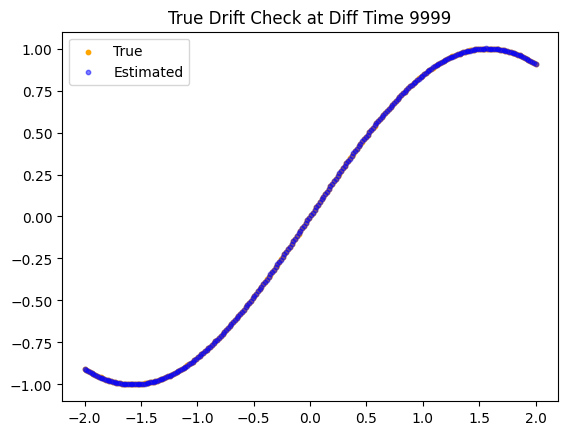

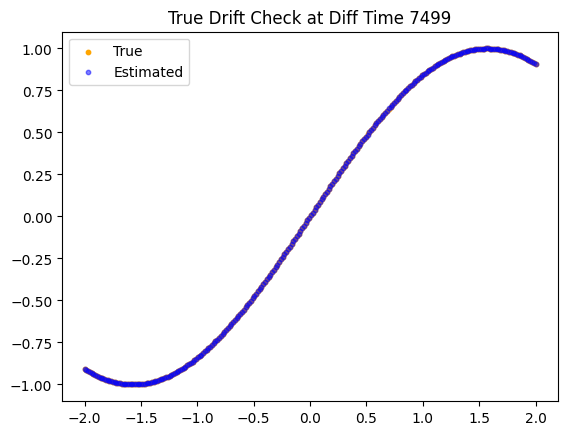

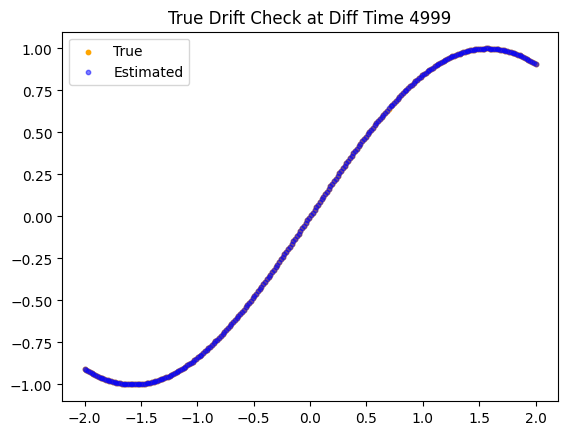

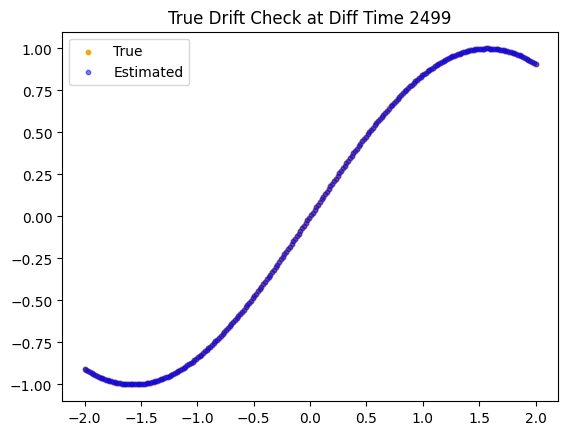

In [14]:
for Nep in [960]:
    save_path = (project_config.ROOT_DIR + f"experiments/results/TSPM_Markovian_ES0_fSin_DriftEvalExp_{Nep}Nep_{config_postmean.loss_factor}LFactor_10MeanRev_{config_postmean.max_diff_steps}DiffSteps").replace(".","")
    try:
        postMean_prevPaths = torch.linspace(-2, 2, 256)#torch.load(save_path + "_prevPaths")
        true_drift = torch.load(save_path + "_driftTrue")
        for diffTime in range(0, config_postmean.max_diff_steps, 2500):
            plt.scatter(postMean_prevPaths, get_true_drift(config_postmean, postMean_prevPaths), s=10, color="orange",label="True")
            plt.scatter(postMean_prevPaths, torch.mean(true_drift[:,:,config_postmean.max_diff_steps-1-diffTime], dim=0), alpha=0.5, s=10,color="blue", label="Estimated")
            plt.title(f"True Drift Check at Diff Time {config_postmean.max_diff_steps-1-diffTime}")
            plt.legend()
            plt.show()
    except FileNotFoundError as e:
        pass

In [13]:
# Compute and store MSE for estimated drifts
experiment_emses = {Nep: None for Nep in [960]}
minbiasses = {Nep: None for Nep in [960]}
for Nep in [960]:
    save_path = (project_config.ROOT_DIR + f"experiments/results/TSPM_Markovian_ES0_fSin_DriftEvalExp_{Nep}Nep_{config_postmean.loss_factor}LFactor_10MeanRev_{config_postmean.max_diff_steps}DiffSteps").replace(".","")
    try:
        postMean_prevPaths = torch.linspace(-2, 2, 256).numpy()#torch.load(save_path + "_prevPaths")
        drift_est = torch.load(save_path + "_driftEst").numpy()[:,:,:10]
        true_drift = get_true_drift(config_postmean, postMean_prevPaths)
        print(true_drift.shape, drift_est.shape)
        print((true_drift[np.newaxis,:, np.newaxis] - drift_est).shape)
        emses = np.power(true_drift[np.newaxis,:, np.newaxis] - drift_est,2).mean(axis=0)
        variance = np.std(true_drift[np.newaxis,:, np.newaxis] - drift_est, axis=0)
        del drift_est, postMean_prevPaths, true_drift
        experiment_emses[Nep] = emses
        minbiasses[Nep] = np.argmin(emses, axis=1)
    except FileNotFoundError as e:
        print(e)
        pass

(256,) (500, 256, 10)
(500, 256, 10)


RuntimeError: 

# Plot the average of the drift estimates for each time t_i as a function of state (X)

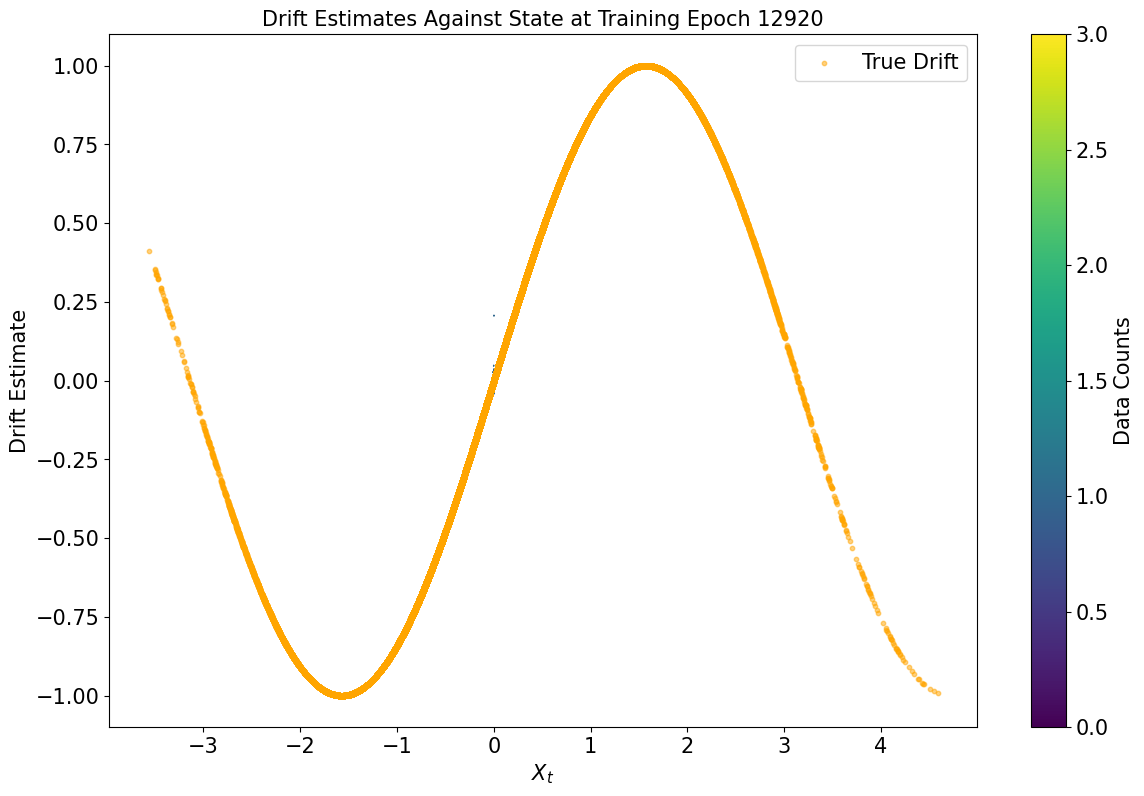

In [13]:
fig, ax = plt.subplots(figsize=(14, 9))
for Nep in [960]:
    save_path = (project_config.ROOT_DIR + f"experiments/results/TSPM_Markovian_ES0_fSin_DriftEvalExp_{Nep}Nep_{config_postmean.loss_factor}LFactor_10MeanRev_{config_postmean.max_diff_steps}DiffSteps").replace(".","")
    try:
        postMean_prevPaths = torch.load(save_path + "_prevPaths").numpy()
        drift_est = torch.load(save_path + "_driftEst").numpy()
        true_drift = get_true_drift(config_postmean, postMean_prevPaths)
        num_bins = 100
        total_counts = None
        combined_x = []
        combined_y = []
        # Accumulate data for all time steps
        for t in range(1, eval_ts_length):
            x_data = [postMean_prevPaths[:, t].mean()]
            y_data = [drift_est[:, t, minbiasses[Nep][t]].mean()]

            # Append data points for all time points
            combined_x.extend(x_data)
            combined_y.extend(y_data)
        # Accumulate total counts from hexbin
        hb = ax.hexbin(combined_x, combined_y, gridsize=num_bins, cmap='viridis', mincnt=1)
        total_counts = hb.get_array()

        # Set color limits based on the total counts
        hb.set_clim(0, np.max(total_counts))

        # Create the colorbar for the combined counts
        cbar = plt.colorbar(hb, ax=ax)
        cbar.ax.tick_params(labelsize=15)
        cbar.set_label('Data Counts', fontsize=15)

        # Plot the true drift scatter plot
        plt.scatter(postMean_prevPaths, true_drift, s=10, alpha=0.5, color="orange", label="True Drift")
        plt.legend(fontsize=15)
        plt.title(f"Drift Estimates Against State at Training Epoch {Nep}", fontsize=15)
        plt.xlabel("$X_{t}$", fontsize=15)
        plt.ylabel("Drift Estimate", fontsize=15)
        ax.tick_params(axis='x', labelsize=15)
        ax.tick_params(axis='y', labelsize=15)

        plt.show()
        plt.close()

        del drift_est
    except FileNotFoundError as e:
        pass

## Now do the same but only for some paths


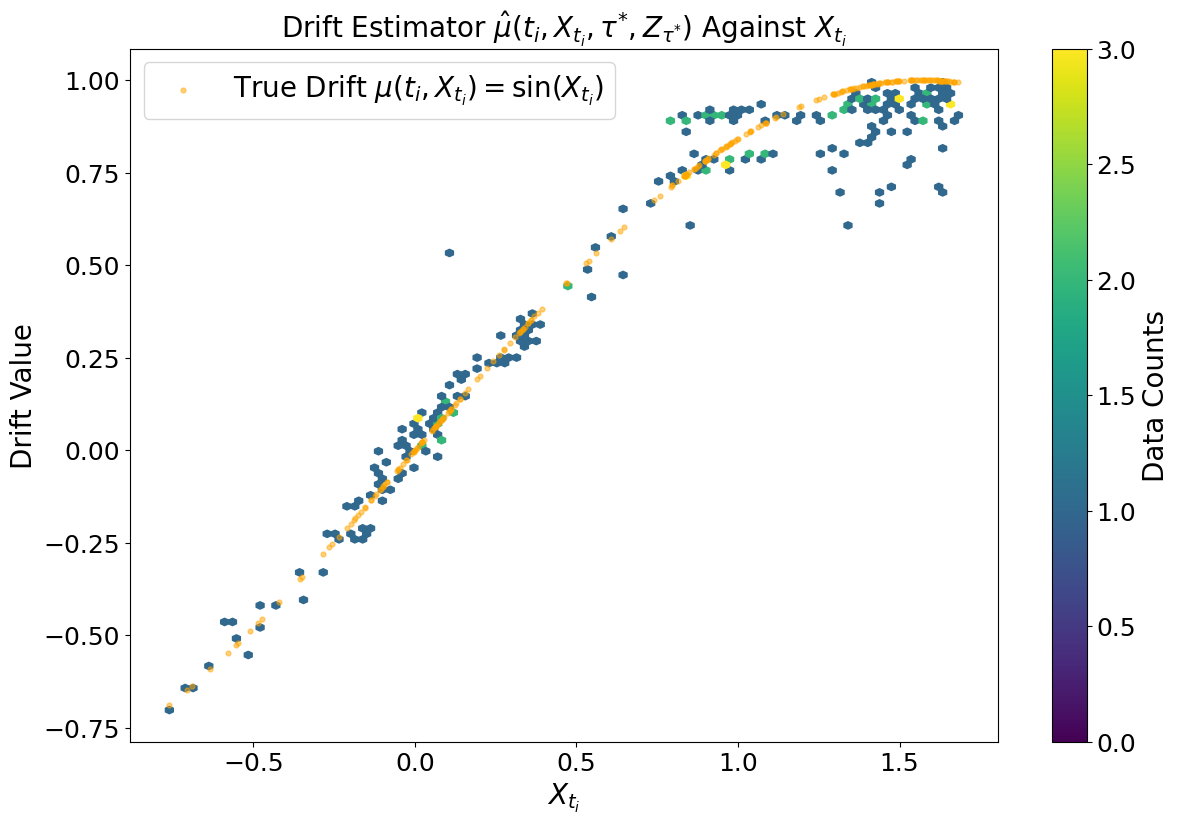

[203]


In [22]:
fig, ax = plt.subplots(figsize=(14, 9))
for Nep in [960]:
    save_path = (project_config.ROOT_DIR + f"experiments/results/TSPM_Markovian_ES0_fSin_DriftEvalExp_{Nep}Nep_{config_postmean.loss_factor}LFactor_10MeanRev_{config_postmean.max_diff_steps}DiffSteps").replace(".","")
    try:
        postMean_prevPaths = torch.load(save_path + "_prevPaths").numpy()
        drift_est = torch.load(save_path + "_driftEst").numpy()
        true_drift = get_true_drift(config_postmean, postMean_prevPaths)
        num_bins = 100
        total_counts = None
        combined_x = []
        combined_y = []
        path_idx = np.random.choice(np.arange(postMean_prevPaths.shape[0]), size=1)
        # Accumulate data for all time steps
        for t in range(1, eval_ts_length):
            x_data = postMean_prevPaths[[path_idx], t]
            y_data = drift_est[[path_idx], t, minbiasses[Nep][t]]

            # Append data points for all time points
            combined_x.extend(x_data)
            combined_y.extend(y_data)

        # Accumulate total counts from hexbin
        hb = ax.hexbin(combined_x, combined_y, gridsize=num_bins, cmap='viridis', mincnt=1)
        total_counts = hb.get_array()

        # Set color limits based on the total counts
        hb.set_clim(0, np.max(total_counts))

        # Create the colorbar for the combined counts
        cbar = plt.colorbar(hb, ax=ax)
        cbar.ax.tick_params(labelsize=18)
        cbar.set_label('Data Counts', fontsize=20)

        # Plot the true drift scatter plot
        plt.scatter(postMean_prevPaths[path_idx, :], true_drift[path_idx,:], s=12, alpha=0.5, color="orange", label="True Drift $\mu(t_i, X_{t_i}) = \sin(X_{t_i})$")
        plt.legend(fontsize=20)
        plt.title("Drift Estimator $\hat{\mu}(t_i, X_{t_i}, \\tau^{*}, Z_{\\tau^{*}})$ Against $X_{t_i}$", fontsize=20)
        plt.xlabel("$X_{t_i}$", fontsize=20)
        plt.ylabel("Drift Value", fontsize=20)
        ax.tick_params(axis='x', labelsize=18)
        ax.tick_params(axis='y', labelsize=18)
        #plt.savefig("/Users/marcos/Library/CloudStorage/OneDrive-ImperialCollegeLondon/StatML_CDT/Year2/DiffusionModelPresentationImages/driftpath1.png")
        plt.show()
        plt.close()
        print(path_idx)
       #del drift_est
    except FileNotFoundError as e:
        pass

# Plot the drift as a function of state for different SDE times

In [7]:
try:
    del postMean_prevPaths, drift_est, true_drift
except NameError as e:
    pass
Nep = [960][0]
save_path = (project_config.ROOT_DIR + f"experiments/results/TSPM_Markovian_ES0_fSin_DriftEvalExp_{Nep}Nep_{config_postmean.loss_factor}LFactor_10MeanRev_{config_postmean.max_diff_steps}DiffSteps").replace(".","")
fig, ax = plt.subplots(figsize=(10, 8))
postMean_prevPaths = torch.load(save_path + "_prevPaths")
drift_est = torch.load(save_path + "_driftEst")
true_drift = get_true_drift(config_postmean, postMean_prevPaths)

# Create initial hexbin plot to get the color mapping
hb = ax.hexbin(postMean_prevPaths[:, 0], drift_est[:, 0, minbiasses[Nep][0]], mincnt=1, cmap='viridis')
cbar = plt.colorbar(hb, ax=ax)  # Create colorbar based on initial hexbin plot
cbar.ax.tick_params(labelsize=15)  # Set colorbar tick font size
cbar.set_label('Number of Samples', fontsize=15)   # Set colorbar label font size

def update(frame):
    ax.clear()  # Clear the previous histogram
    hb = ax.hexbin(postMean_prevPaths[:, frame], drift_est[:,frame, minbiasses[Nep][frame]], mincnt=1)

    cbar.mappable.set_array(hb.get_array())  # Update colorbar with the current hexbin data
    fig.draw_without_rendering()
    ax.scatter(postMean_prevPaths[:, frame], true_drift[:, frame], s=20, alpha=0.5, color="orange", label=rf"True Drift $\sin(\tilde{{X}}_{{t_{{{frame}}}}})$")

    ax.legend(fontsize=15)

    ax.set_title(rf"Drift Estimator $\hat{{\mu}}({{t_{{{frame}}}}}, \tilde{{X}}_{{t_{{{frame}}}}}, \tau^*, Z_{{\tau^*}})$ Against $ \tilde{{X}}_{{t_{{{frame}}}}}$", fontsize=20)
    ax.set_xlabel(rf"$\tilde{{X}}_{{t_{{{frame}}}}}$", fontsize=20)
    ax.set_ylabel(rf"Drift Value at time ${{t_{{{frame}}}}}$", fontsize=20)
    ax.tick_params(axis='x', labelsize=18)  # Set x-axis tick size to 12
    ax.tick_params(axis='y', labelsize=18)

ani = FuncAnimation(fig, update, frames=range(1, eval_ts_length, 30), interval=1000/1, repeat=False)
ani.save("/Users/marcos/Library/CloudStorage/OneDrive-ImperialCollegeLondon/StatML_CDT/Year2/DiffusionModelPresentationImages/gif.gif", writer="pillow")
plt.close(fig)
display(HTML(ani.to_jshtml()))  # Converts animation to JavaScript HTML5 format# Converts animation to JavaScript HTML5 format

1
1
31
61
91
121
151
181
211
241
1
1
31
61
91
121
151
181
211
241


# Compare the density of the true drift values against the estimated drifts

In [ ]:
for Nep in [960]:
    save_path = (project_config.ROOT_DIR + f"experiments/results/TSPM_Markovian_ES0_fSin_DriftEvalExp_{Nep}Nep_{config_postmean.loss_factor}LFactor_10MeanRev_{config_postmean.max_diff_steps}DiffSteps").replace(".","")
    try:
        fig, ax = plt.subplots(figsize=(14, 9))
        postMean_prevPaths = torch.load(save_path + "_prevPaths").numpy()
        drift_est = torch.load(save_path + "_driftEst").numpy()
        opt_ests = []
        for t in range(eval_ts_length):
            curr_drift_est = drift_est[:, t, minbiasses[Nep][t]]
            assert(curr_drift_est.shape == (postMean_prevPaths.shape[0], ))
            opt_ests.append(curr_drift_est)
        plt.hist(np.concatenate(opt_ests).flatten(), bins=300, alpha=0.5, density=True, color="blue", label="Estimated Drifts")
        true_drift = get_true_drift(config_postmean, postMean_prevPaths)
        plt.hist(true_drift.flatten(), bins=300, alpha=0.5, density=True, color="orange", label="True Drift")
        ax.legend(fontsize=15)
        ax.set_xlabel("Drift Values", fontsize=15)
        ax.set_ylabel("Density", fontsize=15)
        ax.set_title("Densities of True vs Optimally Estimated Drifts", fontsize=15)
        ax.tick_params(labelsize=15)
        ax.tick_params(labelsize=15)
        plt.show()
        plt.close()
        del postMean_prevPaths, drift_est
    except FileNotFoundError as e:
        pass

# Plot the drift MSE across diffusion times and different real times

In [ ]:
# Create a color map for 256 points
fig, ax = plt.subplots(figsize=(14,9))
min_drifts = {Nep: [] for Nep in [960]}
cmap = cm.viridis  # You can choose any color map
norm = plt.Normalize(vmin=0, vmax=1)
taus = np.linspace(0, 1, config_postmean.max_diff_steps).flatten()
for Nepoch, values in experiment_emses.items():
    for t in range(eval_ts_length):
        plt.scatter(taus, values[t, :], s=10, color=cmap(t / (eval_ts_length - 1) ))
        min_drifts[Nepoch].append(np.min(values[t, :]))
    taus = np.linspace(0, 1, config_postmean.max_diff_steps).flatten()
    epsilontaus = values.mean(axis=0).flatten()
    #ax.scatter(taus, epsilontaus, s=10, color=cmap(0 / (eval_ts_length - 1) ))
    #ax.axvline(taus[np.argmin(epsilontaus)], 0, np.argmin(values.mean(axis=0)), label="$\\tau^*=$"+f"{round(taus[np.argmin(epsilontaus)], 3)}" )
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])  # We have to set the array to empty for ScalarMappable
    cbar = plt.colorbar(sm)
    cbar.ax.tick_params(labelsize=15)  # Set colorbar tick font size
    cbar.set_label('Real Time', fontsize=15)   # Set colorbar label font size
    plt.title("Drift Estimator MSE $\epsilon(\\tau)$", fontsize=20)
    plt.xlabel("Diffusion Time $\\tau$", fontsize=20)
    plt.ylabel("$\epsilon(\\tau)$", fontsize=20)
    plt.legend(fontsize=20)
    ax.tick_params(axis='x', labelsize=18)  # Set x-axis tick size to 12
    ax.tick_params(axis='y', labelsize=18)
    plt.yscale("log")
    plt.savefig("/Users/marcos/Library/CloudStorage/OneDrive-ImperialCollegeLondon/StatML_CDT/Year2/DiffusionModelPresentationImages/diffusionerrortau.png")
    plt.show()
    plt.close()

# Plot the drift MSE across two real times

In [ ]:
# Create a color map for 256 points
fig, ax = plt.subplots(figsize=(14,9))
min_drifts = {Nep: [] for Nep in [960]}
taus = np.linspace(0, 1, config_postmean.max_diff_steps).flatten()
for Nepoch, values in experiment_emses.items():
    for t in range(2,eval_ts_length, 240):
        if t == 2:
            ax.scatter(taus, values[t, :],color="skyblue", s=20,label="$\epsilon(\mathit{t_{2}}, \\tau)$")
        else:
            ax.scatter(taus, values[t, :], color="sandybrown", s=20,label="$\epsilon(t_{240}, \\tau)$")
        min_drifts[Nepoch].append(np.min(values[t, :]))
    #ax.scatter(taus, epsilontaus, s=10, color=cmap(0 / (eval_ts_length - 1) ))
    ax.axvline(taus[np.argmin(values[2,:])], 0, max((np.max(values[2, :]), np.max(values[t, :]))), color="skyblue",label="$\\tau^*=$"+f"{round(taus[np.argmin(values[2,:])], 3)}" )
    ax.axvline(taus[np.argmin(values[t,:])], 0, max((np.max(values[2, :]), np.max(values[t, :]))),  color="sandybrown",label="$\\tau^*=$"+f"{round(taus[np.argmin(values[t,:])], 3)}" )
    plt.title("Drift Estimator MSE $\epsilon(\mathit{t_i},\\tau)$", fontsize=20)
    plt.xlabel("Diffusion Time $\\tau$", fontsize=20)
    plt.ylabel("$\epsilon(\mathit{t_i}, \\tau)$", fontsize=20)
    plt.legend(fontsize=20)
    ax.tick_params(axis='x', labelsize=18)  # Set x-axis tick size to 12
    ax.tick_params(axis='y', labelsize=18)
    plt.yscale("log")
    plt.savefig("/Users/marcos/Library/CloudStorage/OneDrive-ImperialCollegeLondon/StatML_CDT/Year2/DiffusionModelPresentationImages/diffusionerrortau.png")
    plt.show()
    plt.close()

# Plot the minimum drift MSE across real time

In [ ]:
# Compute mean and bias2 for the drift estimates across different diffusion times
for Nepoch, values in min_drifts.items():
    try:
        fig, ax = plt.subplots(figsize=(14, 9))
        plt.scatter(np.linspace(0, 1., eval_ts_length), values, s=10, label=f"Epoch {Nepoch}")
        plt.title(f"Minimum MSE of Drift Estimator Across Real Times", fontsize=15)
        plt.xlabel("Real Time", fontsize=15)
        plt.ylabel("Minimum Drift MSE", fontsize=15)
        ax.tick_params(axis='x', labelsize=15)  # Set x-axis tick size to 12
        ax.tick_params(axis='y', labelsize=15)
        plt.yscale("log")
        plt.show()
        plt.close()
    except TypeError:
        pass

# Implement non-parametric Bandi and Phillips Drift Estimator on a per-path basis

In [3]:
from scipy.stats import norm
def gaussian_kernel(u):
    return norm.pdf(u)

# Drift estimation function
def cv_nadaraya_watson_estimate_drift(x0, path, delta_X, c_const):
    h = c_const*(path.shape[0] ** (-0.2))
    path_incs = np.diff(path)
    weights = gaussian_kernel((path[:-1] - x0) / h)
    numerator = np.sum(weights * path_incs)
    denominator = np.sum(weights)
    return numerator / (delta_X * denominator) if denominator != 0 else 0

In [ ]:
# Step 1: Linking global and local (FDA vs SDE) parameterisations
# 1.1: (3.4) and (3.5) to establish bijective correspondence between drift/diffusion and mean/covariance (local vs global)
# 1.2: Offdiagonal elements of covariance matrices of observations are proxies for the second moment function of the latent process
# 1.2: E[YijYik] = E[X(Tik)X(tik)] + delta_(j,k)*v^2, where Yi is the observed path corrupted by additive noise from the discretely sampled
     # true SDE path, Xi


In [ ]:
# Step 2: Pooling data and estimating the covariance
import statsmodels.api as sm
from scipy.stats import norm

def FDA_SDE_kernel(bw, x):
    return norm.pdf(x / bw) / bw

def optimise_for_betahat(path_observations, time_points, bandwidth, local_poly_smooth_order, num_paths, num_time_points):
    # Note we assume we want to estimate the drift function at the same points as the ones we observe
    assert (path_observations.shape == time_points.shape)
    assert (time_points.shape == (num_paths, num_time_points))
    # Note we assume all paths have the same number of observations and are defined on the same grid size (FOR NOW)
    assert (np.allclose(time_points, time_points[[0], :]))
    eval_time_points = time_points[0, :]
    T_data = time_points.reshape(num_paths, num_time_points, 1, 1) - time_points
    assert np.all([np.allclose(T_data[:,:, i, j], time_points-time_points[i, j]) for i in range(num_time_points) for j in range(num_time_points)])
    # Bethat is the OLS parameter vector from regression path_observations against polynomial expansion of time differences
    assert (T_data.shape == (num_paths, num_time_points, num_paths, num_time_points))
    X_data = np.stack([np.power(T_data, p) for p in range(local_poly_smooth_order+1)])
    assert (X_data.shape == (local_poly_smooth_order + 1, num_paths, num_time_points, num_paths, num_time_points))
    X_flat = X_data.reshape((X_data.shape[0], np.prod(X_data.shape[1:]))).T
    Y = np.vstack([path_observations]*(num_paths*num_time_points))
    assert (Y.shape == (num_paths*num_time_points, num_paths, num_time_points))
    Y_flat = Y.flatten()

    kernel_weights = np.sqrt(FDA_SDE_kernel(bw=bandwidth, x=T_data))
    assert (kernel_weights.shape == (num_paths, num_time_points, num_paths, num_time_points))
    betas = sm.WLS(Y_flat, X_flat, weights=kernel_weights.flatten()).fit().params.reshape(-1, 1)
    assert (betas.shape == (local_poly_smooth_order + 1, 1))
    return betas, eval_time_points

def per_t_optimise_for_betahat(path_observations, time_points, bandwidth, local_poly_smooth_order, num_paths, num_time_points):
    # Note we assume we want to estimate the drift function at the same points as the ones we observe
    assert (path_observations.shape == time_points.shape)
    assert (time_points.shape == (num_paths, num_time_points))
    # Note we assume all paths have the same number of observations and are defined on the same grid size (FOR NOW)
    assert (np.allclose(time_points, time_points[[0], :]))
    betas = np.zeros((num_time_points,local_poly_smooth_order + 1))
    eval_time_points = time_points[0, :]
    for tidx in range(num_time_points):
        t = eval_time_points[tidx]
        # Bethat is the OLS parameter vector from regression path_observations against polynomial expansion of time differences
        T_data = time_points - t
        assert (T_data.shape == (num_paths, num_time_points))
        X_data = np.stack([np.power(T_data, p) for p in range(local_poly_smooth_order+1)])
        assert (X_data.shape == (local_poly_smooth_order + 1, num_paths, num_time_points))
        X_flat = X_data.reshape((X_data.shape[0], np.prod(X_data.shape[1:]))).T
        Y_flat = path_observations.flatten()
        kernel_weights = np.sqrt(FDA_SDE_kernel(bw=bandwidth, x=T_data))
        assert (kernel_weights.shape == (num_paths, num_time_points))
        betas[tidx, :] = sm.WLS(Y_flat, X_flat, weights=kernel_weights.flatten()).fit().params
    assert (betas.shape == (num_time_points, local_poly_smooth_order + 1))
    mean_hat_t = betas[:,0]
    assert (mean_hat_t.shape == (num_time_points, ))
    delta_mean_hat_t = betas[:, 1] / bandwidth
    assert (delta_mean_hat_t.shape == (num_time_points, ))
    # 2.3: For now, we can assume the diffusion function is known for convenience (and possibly easier implementation)
    # true_cov = np.nan # TODO
    # cov_hat_t = true_cov
    return mean_hat_t,delta_mean_hat_t, eval_time_points

def estimate_drift_from_iid_paths(eval_time_points, mean_hat_t, delta_mean_hat_t, num_time_points):
    # Step 3: Plug-in estimators
    # 3.1: From Step 2, we can consistently recover the mean and covariance functions of the latent process together with their derivatives
    # 3.2: We plug these into Eq (3.5) i.e., Eq (3.14) to transform global information to local information in the form of drift and diffusion functions
    assert (eval_time_points.shape[0] == num_time_points)
    drift_hats = np.zeros((num_time_points, ))
    for tidx in range(num_time_points):
        drift_hat_t = 0. if mean_hat_t[tidx] == 0. else delta_mean_hat_t[tidx] * 1./mean_hat_t[tidx]
        drift_hats[tidx] = drift_hat_t
    return drift_hats

# Now compare estimators with the score-based estimator

In [ ]:
Nep = [960][0]
save_path = ((project_config.ROOT_DIR + f"experiments/results/TSPM_Markovian_ES0_fSin_DriftEvalExp_{Nep}Nep_{config_postmean.loss_factor}LFactor_10MeanRev_{config_postmean.max_diff_steps}DiffSteps").replace(".","")).replace(".","")
postMean_prevPaths = torch.load(save_path + "_prevPaths").numpy()
drift_est = torch.load(save_path + "_driftEst").numpy()
true_drift = get_true_drift(config_postmean, postMean_prevPaths)
minbiasses = (np.argmin(np.mean(np.power(true_drift[:, :, np.newaxis] - drift_est, 2), axis=0), axis=1))
opt_drift_est = np.concatenate([drift_est[:, [tidx], minbiasses[tidx]] for tidx in range(drift_est.shape[1])], axis=1)

# Use Nadaraya-Watson Estimator on score-generated paths

In [ ]:
for pathid in range(0, opt_drift_est.shape[0], 100):
    path = postMean_prevPaths[pathid, :]
    num_time_points = path.shape[0]
    td = true_drift[pathid, :]
    sb_drift_est = opt_drift_est[pathid, :]
    start_c_consts = 0
    end_c_consts = 1
    found_opt = False
    while not found_opt:
        kernel_drifts = []
        kernel_mses = []
        c_consts = np.logspace(start_c_consts,end_c_consts,100)
        for c_const in c_consts:
            kernel_drift = []
            for pathvalid in range(path.shape[0]):
                x0 = path[pathvalid]
                kernel_drift.append(cv_nadaraya_watson_estimate_drift(x0, path, delta_X = config_postmean.end_diff_time/config_postmean.ts_length, c_const=c_const))
            kernel_drift = np.array(kernel_drift)
            kernel_drifts.append(kernel_drift)
            kernel_mses.append(np.mean(np.power(td-kernel_drift,2)))
        mse_argmin = np.argmin(kernel_mses)
        print(c_consts[mse_argmin])
        kernel_drift_mse = kernel_mses[mse_argmin]
        kernel_drifts = kernel_drifts[mse_argmin]
        if 0 < mse_argmin < 100 - 1:
            found_opt = True
        elif mse_argmin == 0:
            start_c_consts -= 1
            end_c_consts -= 1
        else:
            start_c_consts += 1
            end_c_consts += 1

    sb_d_mse = np.mean(np.power(td-sb_drift_est,2))
    fig, ax = plt.subplots(figsize=(14, 8))
    plt.scatter(path, td, color="orange", label="True Drift")
    plt.scatter(path, kernel_drifts, color="green", label=f"ND Estimate: MSE {round(kernel_drift_mse, 3)}")
    plt.scatter(path, sb_drift_est, color="blue", label=f"Score-Based Drift Estimator: MSE {round(sb_d_mse, 3)}")
    plt.legend(fontsize=15)
    plt.xlabel("$X_{t}$", fontsize=15)
    plt.ylabel("Drift Estimate", fontsize=15)
    plt.title("Comparison of Drift Estimators", fontsize=15)
    ax.tick_params(labelsize=15)
    plt.show()
    plt.close()

# Use IID Path Estimator on score-generated paths

In [ ]:
local_poly_smooth_order = 2#int(np.ceil(2*s/(1.-2*s)))
num_time_points = postMean_prevPaths.shape[1]
num_paths = postMean_prevPaths.shape[0]
dt = config_postmean.end_diff_time/config_postmean.ts_length
path_observations = postMean_prevPaths
T_tr = (np.arange(0, num_time_points) * dt).reshape(-1, 1)
time_points = np.vstack([T_tr.T for _ in range(num_paths)])

In [ ]:
start_c_consts = 0
end_c_consts = 1
num_c_consts = 10
found_opt = False
while not found_opt:
    drift_hats = []
    drift_hats_mses = []
    c_consts = np.logspace(start_c_consts,end_c_consts,num_c_consts)
    for c_const in c_consts:
        bandwidth = c_const * (np.log(num_paths) / num_paths) ** (1./(2*(local_poly_smooth_order + 1)))
        mean_hat_t, delta_mean_hat_t, eval_time_points = per_t_optimise_for_betahat(path_observations=path_observations, time_points=time_points, bandwidth=bandwidth, local_poly_smooth_order=local_poly_smooth_order, num_paths=num_paths, num_time_points=num_time_points)
        # Step 3: Plug-in estimator
        drift_hat = estimate_drift_from_iid_paths(eval_time_points=eval_time_points, mean_hat_t=mean_hat_t, delta_mean_hat_t=delta_mean_hat_t, num_time_points=num_time_points)
        time_mse = np.mean(np.power(drift_hat - (config_postmean.mean_rev), 2))
        drift_hats.append(drift_hat)
        drift_hats_mses.append(time_mse)
    mse_argmin = np.argmin(drift_hats_mses)
    print(c_consts[mse_argmin])
    time_mse = drift_hats_mses[mse_argmin]
    drift_hats = drift_hats[mse_argmin]
    if 0 < mse_argmin < num_c_consts - 1:
        found_opt = True
    elif mse_argmin == 0:
        start_c_consts -= 1
        end_c_consts -= 1
    else:
        start_c_consts += 1
        end_c_consts += 1

In [ ]:
fig, ax = plt.subplots(figsize=(14, 8))
plt.scatter(eval_time_points, drift_hats, color="blue", label=f"Estimated $\mu(t)$ with MSE: {time_mse}")
plt.scatter(eval_time_points[1:], [config_postmean.mean_rev]*(num_time_points-1), color="orange", label="True $\mu(t)$")
plt.title("IID Path Estimation of $\mu(t)$", fontsize=15)
plt.legend(fontsize=15)
plt.ylabel("Time-component of Drift", fontsize=15)
plt.xlabel("Real Time", fontsize=15)
ax.tick_params(labelsize=15)
plt.show()
plt.close()

In [ ]:
for pathid in range(0, opt_drift_est.shape[0], 100):
    path = postMean_prevPaths[pathid, :]
    td = true_drift[pathid, :]
    sb_drift_est = opt_drift_est[pathid, :]
    drift_estimator = drift_hats[1:]*path[1:]
    drift_estimator_mse = round(np.mean(np.power(td[1:]-drift_estimator,2)), 3)
    sb_d_mse = round(np.mean(np.power(td-sb_drift_est,2)), 3)
    fig, ax = plt.subplots(figsize=(14, 9))
    plt.scatter(path, td, color="orange", label="True Drift")
    plt.scatter(path[:-1], drift_estimator, color="green", label=f"Drift Kernel Estimate: MSE {round(drift_estimator_mse, 3)}")
    plt.scatter(path, sb_drift_est, color="blue", label=f"Score-Based Drift Estimator: MSE {round(sb_d_mse, 3)}")
    plt.legend(fontsize=15)
    plt.xlabel("$X_{t}$", fontsize=15)
    plt.ylabel("Drift Estimate", fontsize=15)
    plt.title("Comparison of Drift Estimators", fontsize=15)
    ax.tick_params(labelsize=15)
    plt.show()
    plt.close()